# Пример работы

Импортируем все, что понадобится

In [1]:
from inverse_problem.nn_inversion.main import HyperParams, Model
from inverse_problem import get_project_root
from inverse_problem.milne_edington.me import read_full_spectra

import json
from pprint import pprint
import os
from astropy.io import fits
import matplotlib.pyplot as plt

Все гиперпараметры для обучения сети, для предобработки обучающей выборки находятся в json файле.

In [2]:
path_to_json = os.path.join(get_project_root(), 'res_experiments', 'hps_base_mlp.json')
with open(path_to_json) as f:
    json_data = json.load(f)
    pprint(json_data)

{'batch_size': 20,
 'bottom_net': 'BottomSimpleMLPNet',
 'bottom_output': 40,
 'cont_scale': 40000,
 'factors': [1, 1000, 1000, 1000],
 'hidden_size': 40,
 'logB': True,
 'n_epochs': 5,
 'n_input': 224,
 'per_epoch': 10,
 'predict_ind': [0, 1, 2],
 'source': 'database',
 'top_net': 'TopNet',
 'top_output': 3,
 'transform_type': 'mlp_transform_rescale'}


Для примера возьмем самую простую модель. Она состоит из четырех линейных слоев.

In [3]:
# читаем параметры из файла
hps = HyperParams.from_file(path_to_json=path_to_json)

# изменим размер батча
hps.batch_size = 100

# и количество примеров для обучения
hps.per_epoch = 1000

model = Model(hps)
model.net

FullModel(
  (bottom): BottomSimpleMLPNet(
    (fc1): Linear(in_features=224, out_features=40, bias=True)
    (fc2): Linear(in_features=40, out_features=40, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (top): TopNet(
    (fc1): Linear(in_features=41, out_features=40, bias=True)
    (fc2): Linear(in_features=40, out_features=3, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)

In [ ]:
history = model.train(scheduler=True)

In [4]:
# можем сохранять модель, потом загружать ее
path_to_save = os.path.join(get_project_root(), 'checkpoints', 'mlp_example.pt')
model.save_model(path_to_save)
model.load_model(path_to_save)

In [ ]:
# и продолжить обучение
model.continue_training(path_to_save, scheduler=False)

Посмотрим на работу модели на реальных данных.

In [5]:
filename = os.path.join(get_project_root(), 'data', '20170905_030404\\')
line, cont = read_full_spectra(filename)

100%|██████████| 485/485 [00:02<00:00, 177.91it/s]


In [8]:
# parameter=0 - предсказываем Field Strength
predicted = model.predict_full_image((line, cont), parameter=0)

In [11]:
fits_path = os.path.join(get_project_root(), 'data', '20170905_030404.fits')
reference = fits.open(fits_path)

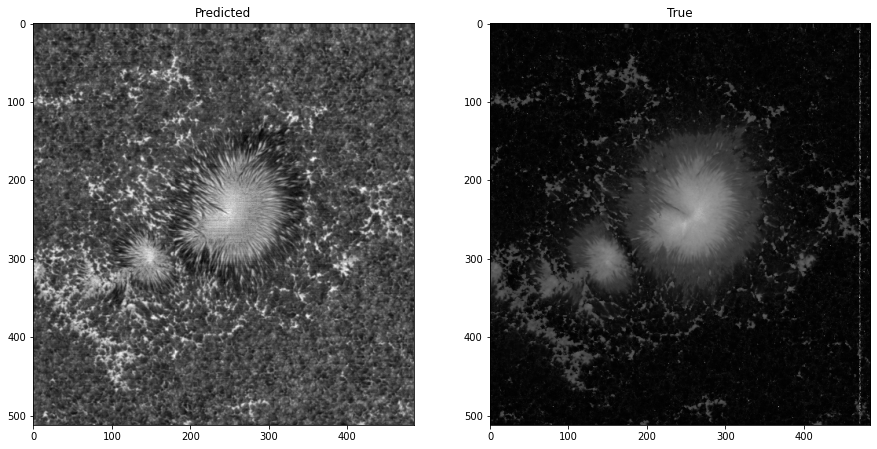

In [9]:
def plot_spectra(pred, true):
  plt.figure(figsize=(15,15))
  plt.subplot(1, 2, 1)
  plt.imshow(pred, cmap='gray')
  plt.title('Predicted')

  plt.subplot(1, 2, 2)
  plt.imshow(true, cmap='gray')
  plt.title('True')

plot_spectra(predicted, reference[1].data)

Пример работы со сверточной моделью

In [4]:
# повторяем все те же действия
path_to_json = os.path.join(get_project_root(), 'res_experiments', 'hps_base_conv.json')
hps = HyperParams.from_file(path_to_json=path_to_json)
hps.batch_size = 256
hps.n_epochs = 5
hps.per_epoch = 2048
model = Model(hps)
model.net

FullModel(
  (bottom): BottomSimpleConv1d(
    (conv1): Sequential(
      (0): Conv1d(4, 32, kernel_size=(2,), stride=(1,), padding=(2,))
      (1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
      (2): ReLU()
      (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv1d(32, 64, kernel_size=(2,), stride=(1,))
      (1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
      (2): ReLU()
      (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (linear): Sequential(
      (0): Linear(in_features=896, out_features=40, bias=True)
      (1): ReLU()
    )
  )
  (top): TopNet(
    (fc1): Linear(in_features=41, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=3, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)

In [5]:
# будем сохраним модель на 3 эпохе
# и включим scheduler.ReduceLROnPlateau, patience=2
path_to_save = os.path.join(get_project_root(), 'checkpoints', 'conv_example_5epochs.pt')
history = model.train(scheduler=True, save_model=True, save_epoch=[3], path_to_save=path_to_save)

epoch:  20%|██        | 1/5 [51:48<3:27:14, 3108.69s/it]



Epoch 001 train_loss: 0.0249          val_loss 0.0144


KeyboardInterrupt: 

In [16]:
model.load_model(path_to_save)

In [22]:
# для входа в сверточную сеть нужно изменить shape входных данных
# line.shape = (485, 512, 224)
line2 = line.reshape((485, 512, 4, 56))

(485, 512, 224)


In [20]:
predicted = model.predict_full_image((line2, cont), 0)

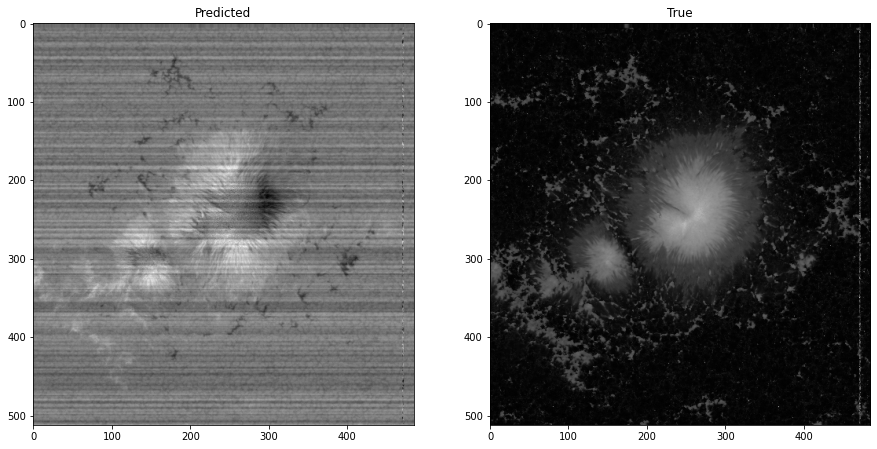

In [21]:
plot_spectra(predicted, reference[1].data)

In [25]:
predicted[0][:20]

array([0.53244352, 0.53251904, 0.53252304, 0.53259838, 0.53260064,
       0.53271276, 0.53226829, 0.53209639, 0.53212583, 0.53204668,
       0.53239715, 0.53262419, 0.53222489, 0.531847  , 0.53193176,
       0.53254968, 0.53242958, 0.53225923, 0.53239161, 0.53217101])